In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report

# Preprocessing & EDA

In [4]:
positive_dir = Path('Data/Positive')
negative_dir = Path('Data/Negative')

In [5]:
#generate dataframe for image with path and label
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [6]:
#apply to both positive and negative, as well as combine into one
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,Data\Negative\02059.jpg,NEGATIVE
1,Data\Negative\18108.jpg,NEGATIVE
2,Data\Negative\10405.jpg,NEGATIVE
3,Data\Negative\07682.jpg,NEGATIVE
4,Data\Negative\01883.jpg,NEGATIVE
...,...,...
4995,Data\Negative\03032.jpg,NEGATIVE
4996,Data\Negative\02046.jpg,NEGATIVE
4997,Data\Positive\07320.jpg,POSITIVE
4998,Data\Negative\11754.jpg,NEGATIVE


Text(0.5, 1.0, 'Negative and Positive')

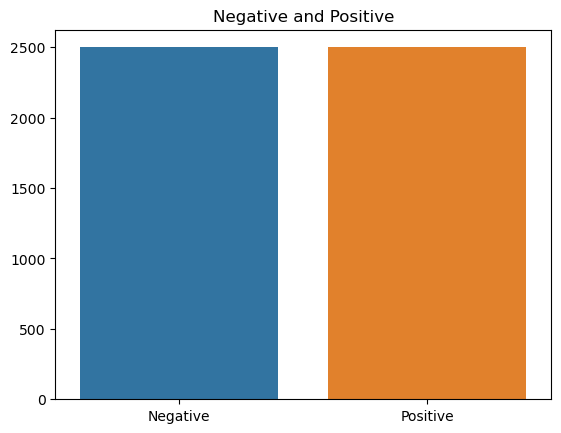

In [7]:
sns.barplot(x=['Negative','Positive'], y=[len(negative_df), len(positive_df)])
plt.title('Negative and Positive')

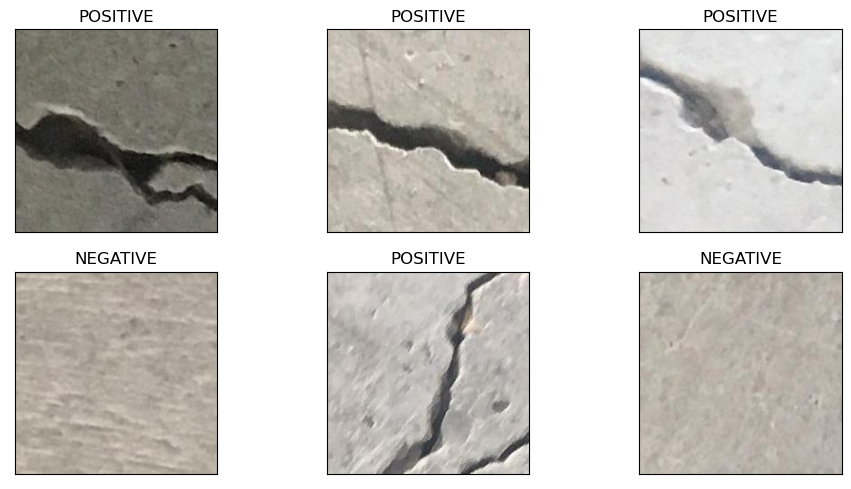

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(all_df.Filepath[i]))
    ax.set_title(all_df.Label[i])
plt.tight_layout()
plt.show()

In [8]:
train_df, test_df = train_test_split(
    all_df.sample(1000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

Loading the image

In [9]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [10]:
#Generate batches of tensor image data with real-time data augmentation.
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 560 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [11]:
train_data

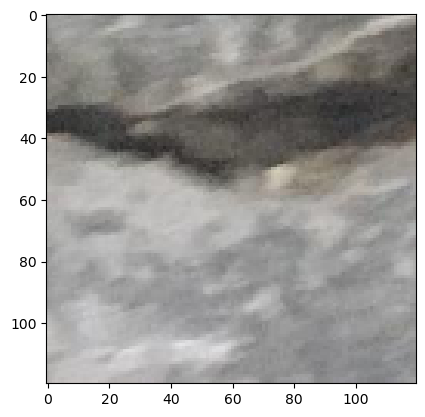

In [12]:
%matplotlib inline
plt.imshow(train_data[0][0][0])

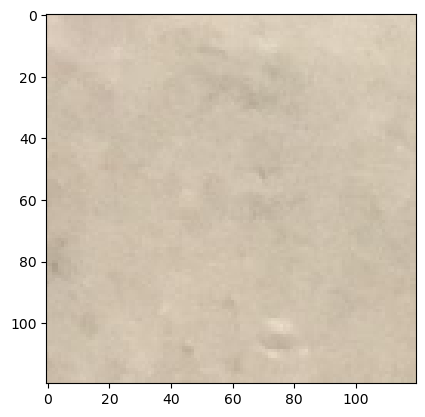

In [13]:
plt.imshow(train_data[0][0][1])

# Model

## Baseline CNN

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras as keras

cnn_model = Sequential()

# feature extraction layer 0: convolution
cnn_model.add(Conv2D(16, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(120, 120, 3)))
# feature extraction layer 1: max pooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# feature extraction layer 2: convolution
cnn_model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(120, 120, 3)))
# feature extraction layer 3: max pooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# classification layer 4: global average pooling
cnn_model.add(GlobalAveragePooling2D())
# classification layer 5: dense non-linear transformation
cnn_model.add(Dense(100, activation='relu'))
# classification layer 6: output label probability
cnn_model.add(Dense(1, activation='sigmoid'))

In [15]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                        

### Training

In [16]:
learning_rate=0.001
weight_decay=0.001
num_epochs = 20
batch_size = 1

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

In [17]:
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate,
                                                  weight_decay=weight_decay),
                  metrics=['accuracy'])

cnn_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/20
18/18 [==============================] - 6s 271ms/step - loss: 0.6909 - accuracy: 0.5625 - val_loss: 0.6849 - val_accuracy: 0.5286
Epoch 2/20
18/18 [==============================] - 4s 205ms/step - loss: 0.6800 - accuracy: 0.5696 - val_loss: 0.6674 - val_accuracy: 0.5786
Epoch 3/20
18/18 [==============================] - 4s 225ms/step - loss: 0.6666 - accuracy: 0.6232 - val_loss: 0.6814 - val_accuracy: 0.5286
Epoch 4/20
18/18 [==============================] - 4s 204ms/step - loss: 0.6468 - accuracy: 0.7125 - val_loss: 0.6220 - val_accuracy: 0.5429
Epoch 5/20
18/18 [==============================] - 4s 210ms/step - loss: 0.6031 - accuracy: 0.7036 - val_loss: 0.5689 - val_accuracy: 0.7786
Epoch 6/20
18/18 [==============================] - 4s 204ms/step - loss: 0.5641 - accuracy: 0.7714 - val_loss: 0.5223 - val_accuracy: 0.8429
Epoch 7/20
18/18 [==============================] - 4s 206ms/step - loss: 0.5012 - accuracy: 0.8375 - val_loss: 0.4410 - val_accuracy: 0.9000
Epoch 

In [18]:
# list all data in history
print(cnn_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


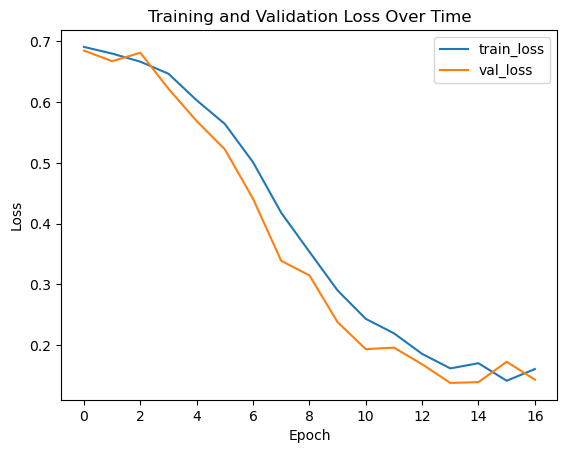

In [19]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

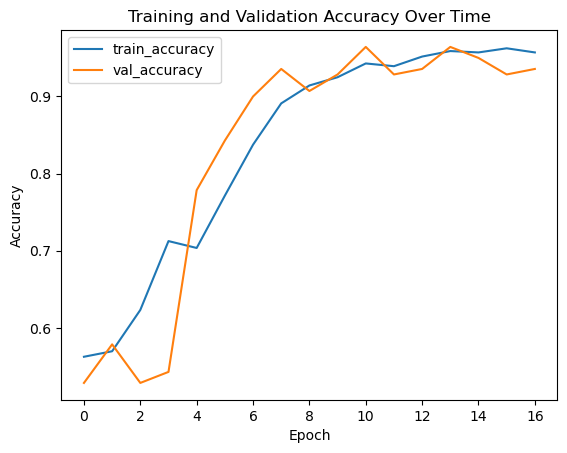

In [20]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Performance Evaluation

In [21]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.14899
Test Accuracy: 96.67%
10/10 [==============================] - 1s 85ms/step


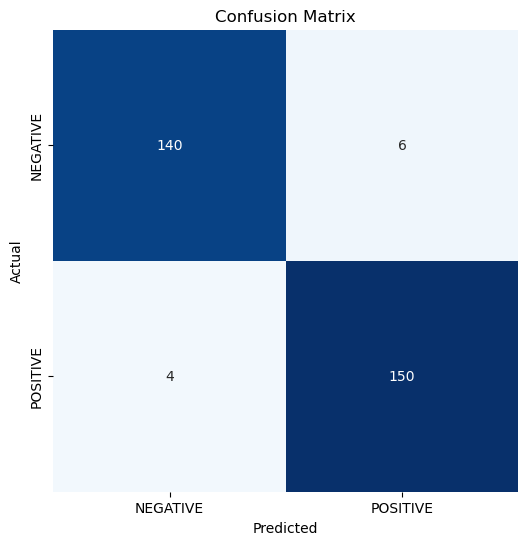

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.96      0.97       146
    POSITIVE       0.96      0.97      0.97       154

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [22]:
evaluate_model(cnn_model, test_data)

Pretrained model source code:
* https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
* https://androidkt.com/how-to-use-vgg-model-in-tensorflow-keras/#:~:text=First%2C%20instantiate%20a%20VGG16%20model,t%20include%20the%20classification%20layers.&text=It's%20important%20to%20freeze%20the,By%20freezing%20or%20setting%20layer.

## VGG-16

In [23]:
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(120, 120, 3),
                                               include_top=False,
                                               weights='imagenet')
VGG16_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')

vgg16_model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  prediction_layer
])

58889256/58889256 [==============================] - 3s 0us/step


In [24]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


### Training

In [25]:
vgg16_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate,
                                                  weight_decay=weight_decay),
                  metrics=['accuracy'])

vgg16_history = vgg16_model.fit(
    train_data,
    validation_data=val_data,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/20
18/18 [==============================] - 49s 3s/step - loss: 0.7290 - accuracy: 0.5196 - val_loss: 0.6404 - val_accuracy: 0.5286
Epoch 2/20
18/18 [==============================] - 48s 3s/step - loss: 0.5988 - accuracy: 0.6768 - val_loss: 0.5427 - val_accuracy: 0.9714
Epoch 3/20
18/18 [==============================] - 48s 3s/step - loss: 0.5136 - accuracy: 0.9589 - val_loss: 0.4682 - val_accuracy: 0.9857
Epoch 4/20
18/18 [==============================] - 47s 3s/step - loss: 0.4475 - accuracy: 0.9786 - val_loss: 0.4081 - val_accuracy: 0.9929
Epoch 5/20
18/18 [==============================] - 48s 3s/step - loss: 0.3946 - accuracy: 0.9821 - val_loss: 0.3596 - val_accuracy: 0.9929
Epoch 6/20
18/18 [==============================] - 48s 3s/step - loss: 0.3513 - accuracy: 0.9875 - val_loss: 0.3201 - val_accuracy: 0.9929
Epoch 7/20
18/18 [==============================] - 48s 3s/step - loss: 0.3156 - accuracy: 0.9893 - val_loss: 0.2885 - val_accuracy: 0.9929
Epoch 8/20
18/18 [==

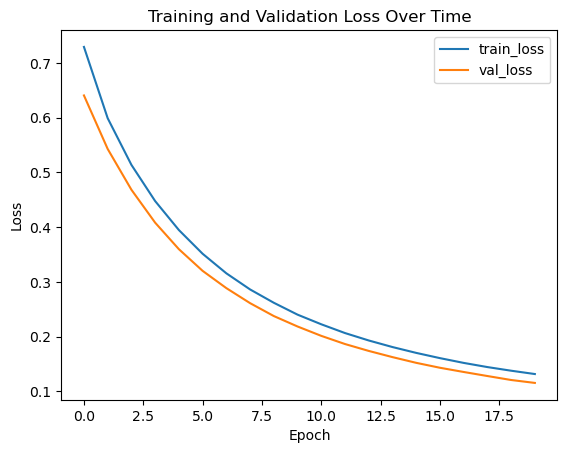

In [26]:
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

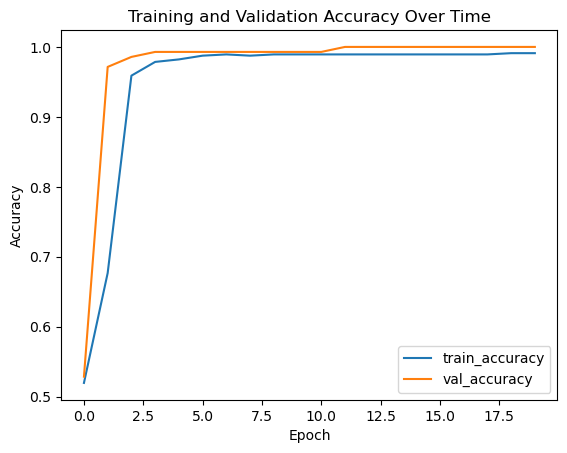

In [27]:
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Performance Evaluation

    Test Loss: 0.14837
Test Accuracy: 97.33%
10/10 [==============================] - 21s 2s/step


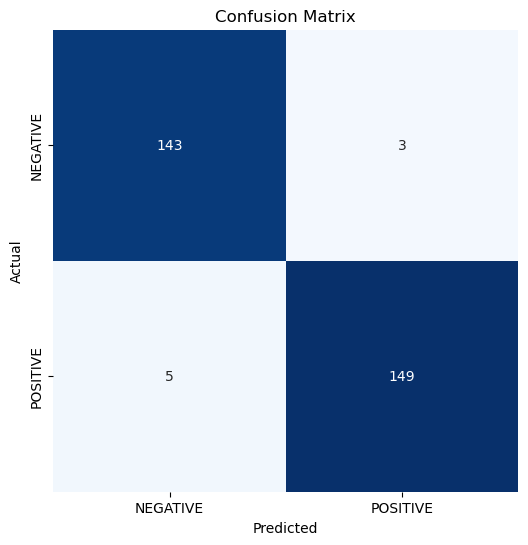

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.98      0.97       146
    POSITIVE       0.98      0.97      0.97       154

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [28]:
evaluate_model(vgg16_model, test_data)

## ResNet50

In [29]:
RESNET50_MODEL=tf.keras.applications.ResNet50(input_shape=(120, 120, 3),
                                           include_top=False,
                                           # pooling='avg',
                                           weights='imagenet')
RESNET50_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')

resnet50_model = tf.keras.Sequential([
  RESNET50_MODEL,
  global_average_layer,
  prediction_layer
])

94765736/94765736 [==============================] - 4s 0us/step


In [30]:
resnet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


### Training

In [31]:
resnet50_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate,
                                                  weight_decay=weight_decay),
                  metrics=['accuracy'])

resnet50_history = resnet50_model.fit(
    train_data,
    validation_data=val_data,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/20
18/18 [==============================] - 21s 974ms/step - loss: 0.6852 - accuracy: 0.5607 - val_loss: 0.6792 - val_accuracy: 0.5286
Epoch 2/20
18/18 [==============================] - 16s 936ms/step - loss: 0.6730 - accuracy: 0.5446 - val_loss: 0.6679 - val_accuracy: 0.9643
Epoch 3/20
18/18 [==============================] - 16s 891ms/step - loss: 0.6628 - accuracy: 0.6679 - val_loss: 0.6568 - val_accuracy: 0.5286
Epoch 4/20
18/18 [==============================] - 16s 888ms/step - loss: 0.6530 - accuracy: 0.8393 - val_loss: 0.6474 - val_accuracy: 0.6643
Epoch 5/20
18/18 [==============================] - 16s 922ms/step - loss: 0.6422 - accuracy: 0.5268 - val_loss: 0.6381 - val_accuracy: 0.5286
Epoch 6/20
18/18 [==============================] - 16s 890ms/step - loss: 0.6340 - accuracy: 0.8946 - val_loss: 0.6291 - val_accuracy: 0.7714
Epoch 7/20
18/18 [==============================] - 16s 916ms/step - loss: 0.6250 - accuracy: 0.6768 - val_loss: 0.6209 - val_accuracy: 0.9714

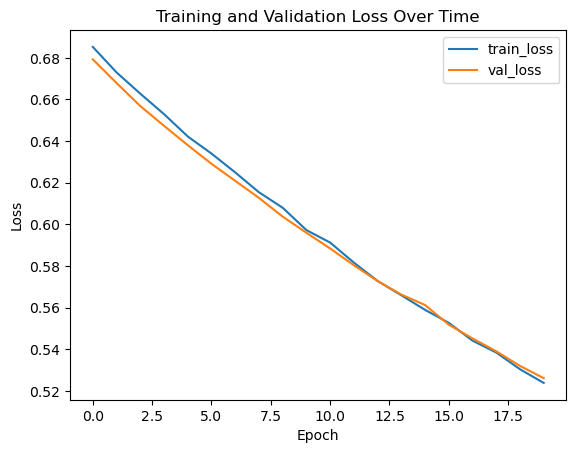

In [32]:
plt.plot(resnet50_history.history['loss'])
plt.plot(resnet50_history.history['val_loss'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

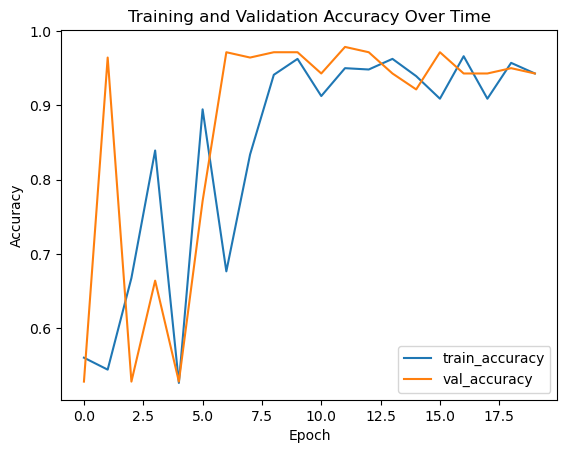

In [33]:
plt.plot(resnet50_history.history['accuracy'])
plt.plot(resnet50_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Performance Evaluation

    Test Loss: 0.52562
Test Accuracy: 92.67%
10/10 [==============================] - 8s 699ms/step


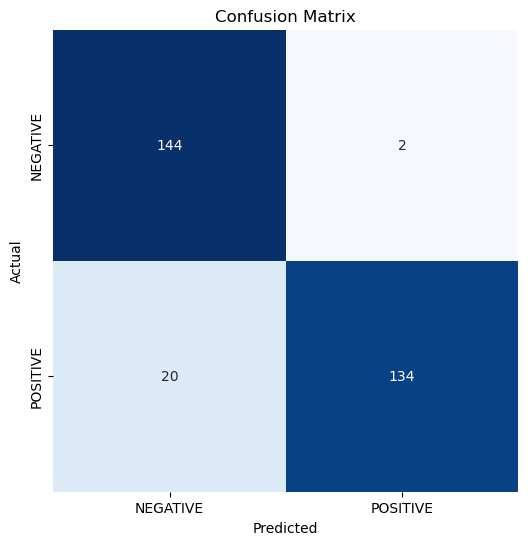

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.88      0.99      0.93       146
    POSITIVE       0.99      0.87      0.92       154

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



In [34]:
evaluate_model(resnet50_model, test_data)

## Inceptionv3

In [35]:
INCEPTIONV3_MODEL=tf.keras.applications.InceptionV3(input_shape=(120, 120, 3),
                                           include_top=False,
                                           # pooling='avg',
                                           weights='imagenet')
INCEPTIONV3_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')

inceptionv3_model = tf.keras.Sequential([
  INCEPTIONV3_MODEL,
  global_average_layer,
  prediction_layer
])

87910968/87910968 [==============================] - 4s 0us/step


In [36]:
inceptionv3_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


### Training

In [37]:
inceptionv3_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate,
                                                  weight_decay=weight_decay),
                  metrics=['accuracy'])

inceptionv3_history = inceptionv3_model.fit(
    train_data,
    validation_data=val_data,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/20
18/18 [==============================] - 15s 572ms/step - loss: 0.3827 - accuracy: 0.8875 - val_loss: 0.1698 - val_accuracy: 0.9929
Epoch 2/20
18/18 [==============================] - 9s 501ms/step - loss: 0.1634 - accuracy: 0.9607 - val_loss: 0.0925 - val_accuracy: 0.9929
Epoch 3/20
18/18 [==============================] - 8s 419ms/step - loss: 0.1101 - accuracy: 0.9804 - val_loss: 0.0657 - val_accuracy: 0.9929
Epoch 4/20
18/18 [==============================] - 9s 478ms/step - loss: 0.0863 - accuracy: 0.9875 - val_loss: 0.0528 - val_accuracy: 1.0000
Epoch 5/20
18/18 [==============================] - 8s 440ms/step - loss: 0.0723 - accuracy: 0.9946 - val_loss: 0.0441 - val_accuracy: 1.0000
Epoch 6/20
18/18 [==============================] - 9s 483ms/step - loss: 0.0618 - accuracy: 0.9929 - val_loss: 0.0404 - val_accuracy: 1.0000
Epoch 7/20
18/18 [==============================] - 7s 415ms/step - loss: 0.0540 - accuracy: 0.9946 - val_loss: 0.0350 - val_accuracy: 1.0000
Epoch

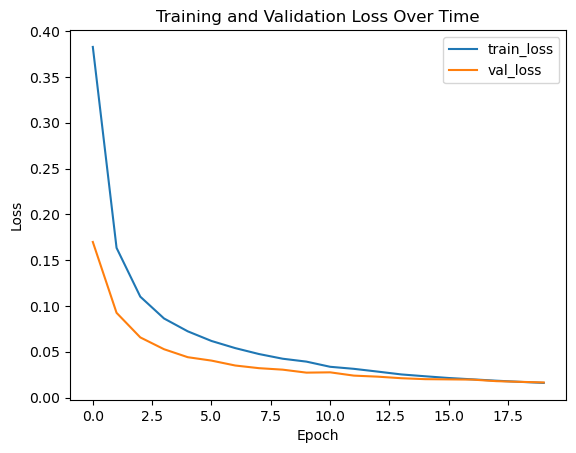

In [38]:
plt.plot(inceptionv3_history.history['loss'])
plt.plot(inceptionv3_history.history['val_loss'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

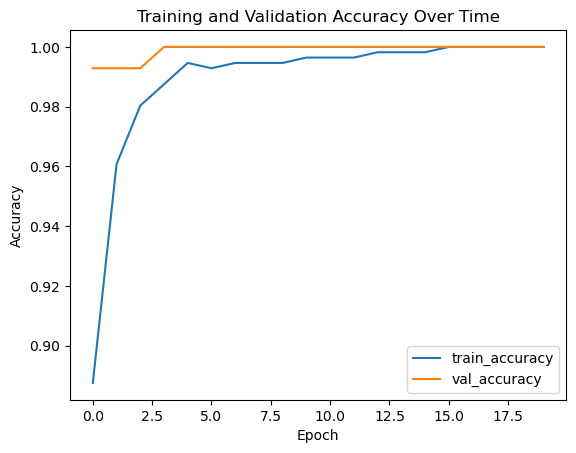

In [39]:
plt.plot(inceptionv3_history.history['accuracy'])
plt.plot(inceptionv3_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Performance Evaluation

    Test Loss: 0.04246
Test Accuracy: 98.67%
10/10 [==============================] - 4s 311ms/step


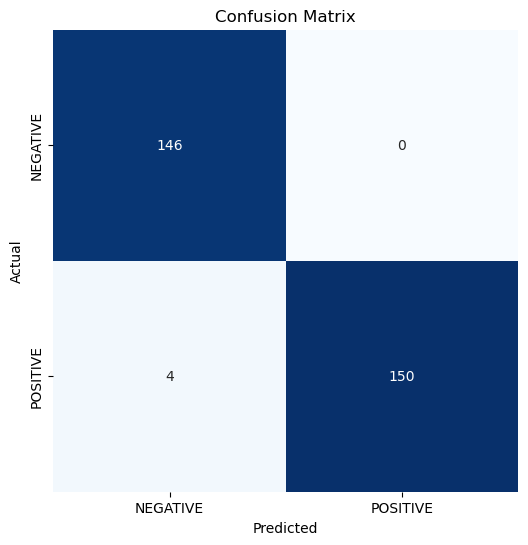

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      1.00      0.99       146
    POSITIVE       1.00      0.97      0.99       154

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [40]:
evaluate_model(inceptionv3_model, test_data)

## Comparing Models

In [41]:
cnn_loss,cnn_accuracy = cnn_model.evaluate(test_data, steps = 20, verbose=0)
vgg16_loss,vgg16_accuracy = vgg16_model.evaluate(test_data, steps = 20, verbose=0)
resnet50_loss,resnet50_accuracy = resnet50_model.evaluate(test_data, steps = 20, verbose=0)
inceptionv3_loss,inceptionv3_accuracy = inceptionv3_model.evaluate(test_data, steps = 20, verbose=0)

model_comparison = pd.DataFrame(data = {'cnn_model':[cnn_loss,cnn_accuracy],
                                        'vgg16_model':[vgg16_loss,vgg16_accuracy],
                                        'resnet50_model':[resnet50_loss,resnet50_accuracy],
                                        'inceptionv3_model':[inceptionv3_loss,inceptionv3_accuracy]},
                                index = ['loss', 'accuracy'])

print('---------------------------------------------------------------------------------------------')
print(model_comparison)

---------------------------------------------------------------------------------------------
          cnn_model  vgg16_model  resnet50_model  inceptionv3_model
loss       0.148990     0.148374        0.525620           0.042461
accuracy   0.966667     0.973333        0.926667           0.986667


## Hyperparameter Tuning

In [42]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01, step=0.001)
    weight_decay = trial.suggest_float('weight_decay', 0.001, 0.01, step=0.001)
    num_epochs = trial.suggest_int('num_epochs', 10, 60,  step=10)
    batch_size = trial.suggest_categorical("batch_size", [1, 20, 40, 60, 80, 100])
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=3,
                                                restore_best_weights=True)

    inceptionv3_model.compile(loss='binary_crossentropy',
                              optimizer=keras.optimizers.Adam(learning_rate=learning_rate,
                                                              weight_decay=weight_decay),
                              metrics=['accuracy'])

    inceptionv3_model.fit(train_data,
                          validation_data=val_data,
                          epochs=num_epochs,
                          batch_size=batch_size,
                          callbacks=[callback],
                          verbose=0)

    val_loss = inceptionv3_model.evaluate(val_data, verbose=0)[0]
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f"Best learning_rate: {study.best_params['learning_rate']}")
print(f"Best weight_decay: {study.best_params['weight_decay']}")
print(f"Best num_epochs: {study.best_params['num_epochs']}")
print(f"Best batch_size: {study.best_params['batch_size']}")
print(f"Best validation loss: {study.best_value}")

[I 2023-04-22 18:07:40,314] A new study created in memory with name: no-name-eadb63e4-2ab4-4aff-926a-9b0c0220ebbf
[I 2023-04-22 18:09:23,606] Trial 0 finished with value: 0.0018205313244834542 and parameters: {'learning_rate': 0.008, 'weight_decay': 0.004, 'num_epochs': 10, 'batch_size': 60}. Best is trial 0 with value: 0.0018205313244834542.
[I 2023-04-22 18:10:38,249] Trial 1 finished with value: 0.0004460696945898235 and parameters: {'learning_rate': 0.006, 'weight_decay': 0.008, 'num_epochs': 20, 'batch_size': 100}. Best is trial 1 with value: 0.0004460696945898235.
[I 2023-04-22 18:11:55,278] Trial 2 finished with value: 0.0001158957602456212 and parameters: {'learning_rate': 0.009000000000000001, 'weight_decay': 0.01, 'num_epochs': 50, 'batch_size': 100}. Best is trial 2 with value: 0.0001158957602456212.
[I 2023-04-22 18:12:58,937] Trial 3 finished with value: 0.0002513360814191401 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.004, 'num_epochs': 50, 'batch_size': 100

Best learning_rate: 0.01
Best weight_decay: 0.002
Best num_epochs: 30
Best batch_size: 80
Best validation loss: 2.6079189410666004e-05


In [43]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [45]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

### Performance Evaluation

In [46]:
best_learning_rate = study.best_params['learning_rate']
best_weight_decay = study.best_params['weight_decay']
best_num_epochs = study.best_params['num_epochs']
best_batch_size = study.best_params['batch_size']

In [47]:
inceptionv3_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate,
                                                  weight_decay=best_weight_decay),
                  metrics=['accuracy'])

best_inceptionv3_history = inceptionv3_model.fit(
    train_data,
    validation_data=val_data,
    epochs=best_num_epochs,
    batch_size=best_batch_size,
    callbacks=[callback]
)

Epoch 1/30
18/18 [==============================] - 15s 574ms/step - loss: 1.4996e-08 - accuracy: 1.0000 - val_loss: 2.8611e-05 - val_accuracy: 1.0000
Epoch 2/30
18/18 [==============================] - 9s 480ms/step - loss: 1.4893e-08 - accuracy: 1.0000 - val_loss: 2.8438e-05 - val_accuracy: 1.0000
Epoch 3/30
18/18 [==============================] - 9s 479ms/step - loss: 1.4777e-08 - accuracy: 1.0000 - val_loss: 2.8182e-05 - val_accuracy: 1.0000
Epoch 4/30
18/18 [==============================] - 9s 484ms/step - loss: 1.4643e-08 - accuracy: 1.0000 - val_loss: 2.8638e-05 - val_accuracy: 1.0000
Epoch 5/30
18/18 [==============================] - 8s 437ms/step - loss: 1.4484e-08 - accuracy: 1.0000 - val_loss: 2.8555e-05 - val_accuracy: 1.0000
Epoch 6/30
18/18 [==============================] - 8s 423ms/step - loss: 1.4253e-08 - accuracy: 1.0000 - val_loss: 2.8626e-05 - val_accuracy: 1.0000


In [48]:
best_inceptionv3_loss,best_inceptionv3_accuracy = inceptionv3_model.evaluate(test_data, steps = 20, verbose=0)
model_comparison['tuned_inceptionv3_model'] = [best_inceptionv3_loss, best_inceptionv3_accuracy]
print(model_comparison)

          cnn_model  vgg16_model  resnet50_model  inceptionv3_model  \
loss       0.148990     0.148374        0.525620           0.042461   
accuracy   0.966667     0.973333        0.926667           0.986667   

          tuned_inceptionv3_model  
loss                     0.073157  
accuracy                 0.990000  


# Interpretbility

## LIME

In [49]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

0.0


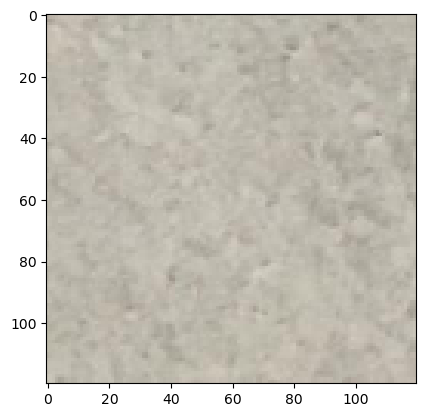

In [50]:
# Get the first batch of data from test_data generator
x_test, y_test = test_data.next()


# Get the first image and its corresponding label
image = x_test[1]
label = y_test[1]

# Print the label of the first image
print(label)
plt.imshow(image)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


(-0.5, 119.5, 119.5, -0.5)

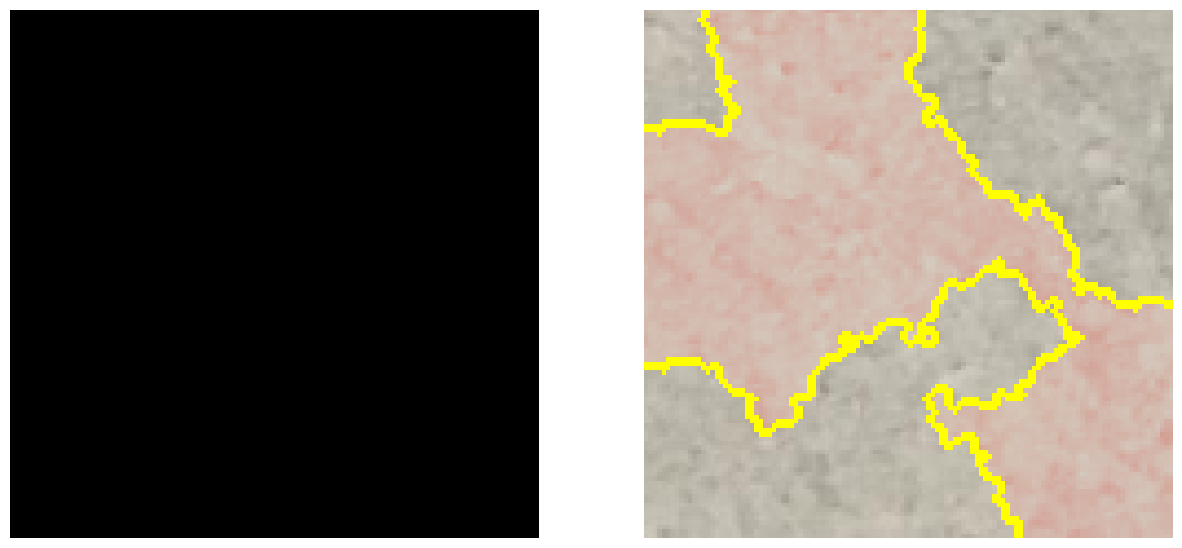

In [51]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         image, 
         cnn_model.predict
)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=4, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 132ms/step


(-0.5, 119.5, 119.5, -0.5)

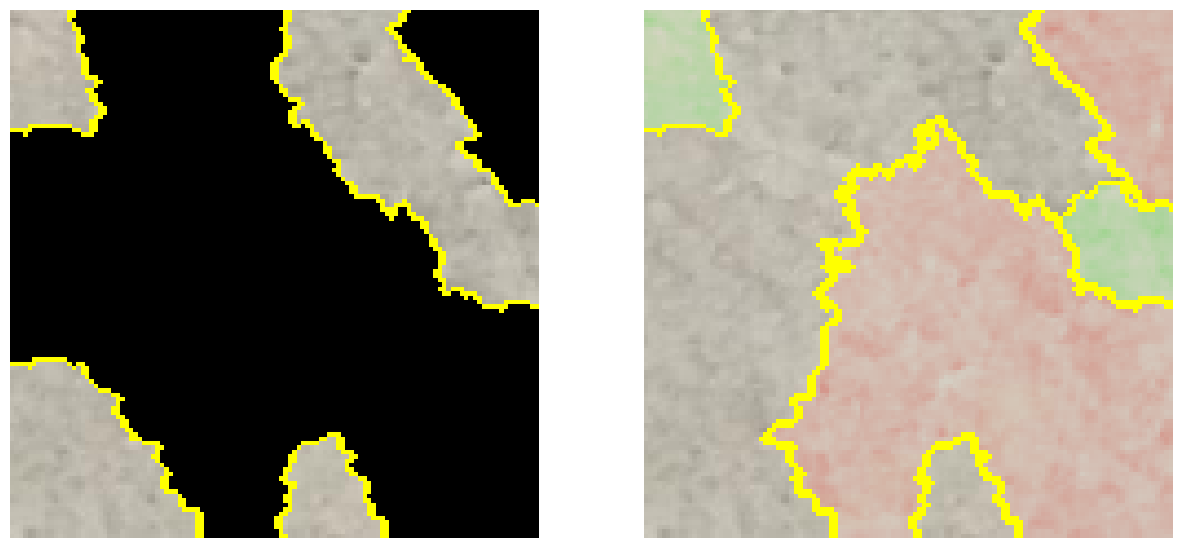

In [52]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         image, 
         inceptionv3_model.predict
)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=7, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=7, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')